In [13]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [15]:
#Loading the dataset
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [17]:
#Date Pre-processing
#Getting basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


In [19]:
#Date column is in object data type so converting it into datatime data type
df['Date'] = pd.to_datetime(df['Date'])

In [21]:
#Checking info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9823 non-null   datetime64[ns]
 1   Open       9822 non-null   float64       
 2   High       9822 non-null   float64       
 3   Low        9822 non-null   float64       
 4   Close      9822 non-null   float64       
 5   Adj Close  9822 non-null   float64       
 6   Volume     9822 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 537.3 KB


In [23]:
#Getting the shape of the dataframe
df.shape

(9823, 7)

In [25]:
#Setting Date column as index
df.set_index('Date',inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [27]:
#Checking null values
df.isnull().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [29]:
#There is one missing value - Since Stock prices are sequential, dropping values is not the best approach
#Using Forward Fill(Where it fills with the previous days values)

df.fillna(method='ffill',inplace=True)

In [31]:
#Checking for null values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

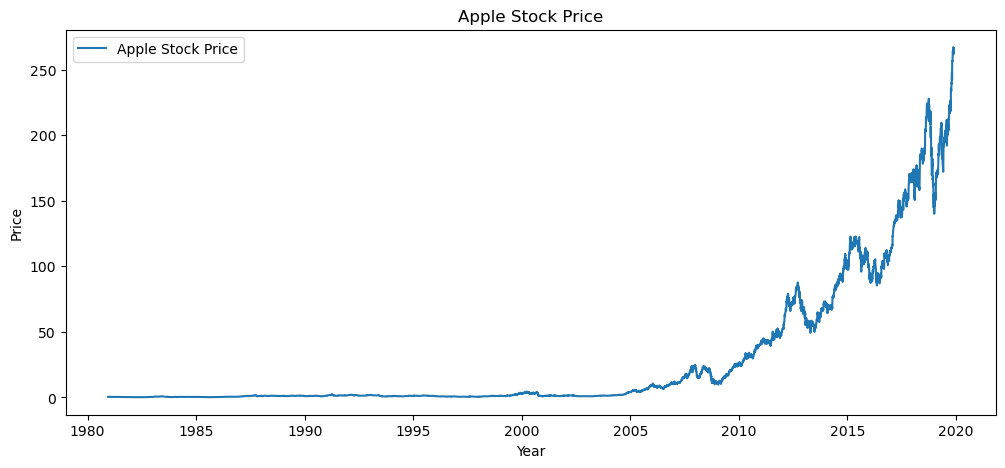

In [33]:
#Visulaization
#Selecting the adjusted Close column
df = df[['Adj Close']]

#Plotting
plt.figure(figsize=(12,5))
plt.plot(df,label='Apple Stock Price')
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [35]:
#Data Preparation for modelling
#Using Min-Max scaler as neural networks works best when features are scaled

#Initializing the scaler
scaler = MinMaxScaler(feature_range=(0,1))

#Fitting and transforming the data
df_scaled = scaler.fit_transform(df)

#Converting back to the dataframe
df_scaled = pd.DataFrame(df_scaled,index=df.index,columns=['Adj Close'])

#Checking the new dataframe
df_scaled.head()

,Adj Close
Date,
1980-12-12,0.000943
1980-12-15,0.000863
1980-12-16,0.000757
1980-12-17,0.000790
1980-12-18,0.000830


In [37]:
# Definining function to create sequences for RNN
def create_sequences(data, time_steps):
    data = np.array(data)
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])  # Past 'time_steps' days
        y.append(data[i + time_steps, 0])  # Next day's price value[1D array]
    return np.array(X), np.array(y)

In [39]:
#Applying the function
stock_prices = df_scaled.to_numpy() #Selecting Adj Clos Column

#Defining time_step(lookback period)
time_steps = 60

#Creating Sequences 
X,y = create_sequences(df_scaled,time_steps)

print(f"X Shape: {X.shape}, y Shape: {y.shape}")

X Shape: (9763, 60, 1), y Shape: (9763,)


In [41]:
# Reshape X for SimpleRNN (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [43]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (7810, 60, 1), Test Shape: (1953, 60, 1)


In [45]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("Final_AAPL_SimpleRNN.h5")

In [47]:
#Predicting the stock prices for the test data
pred_stock_prices = model.predict(X_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [49]:
#Converting predictions back to actual prices
pred_stock_prices = scaler.inverse_transform(pred_stock_prices)
actual_stock_prices = scaler.inverse_transform(y_test.reshape(-1,1))

In [51]:
#Calculating MSE 
mse = mean_squared_error(actual_stock_prices,pred_stock_prices)
print(f"Mean Squared Error(MSE) : {mse}")

Mean Squared Error(MSE) : 18.370028660377844


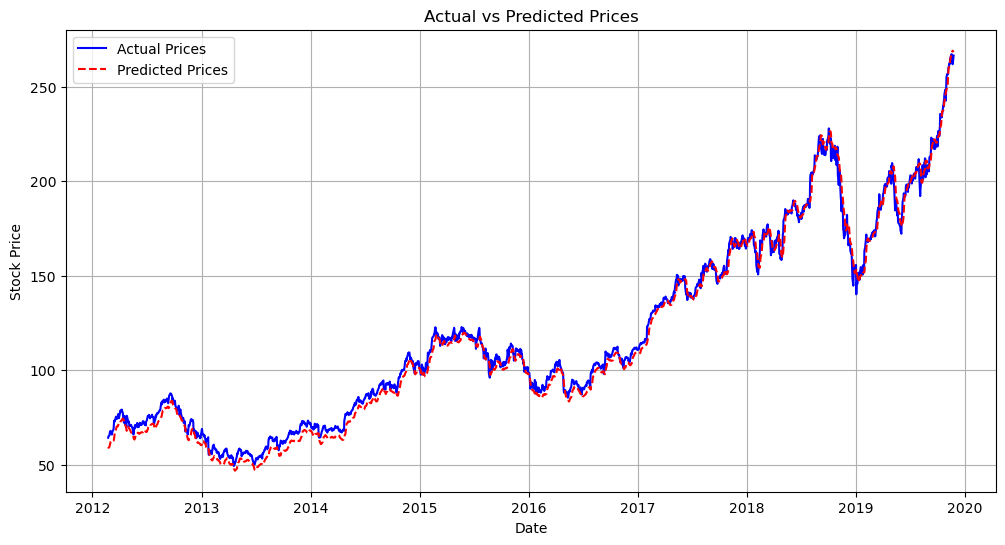

In [57]:
#Visualizing the actual and predicted stock prices
dates = df.index[-len(actual_stock_prices):]
plt.figure(figsize=(12,6))
plt.plot(dates,actual_stock_prices,label = 'Actual Prices',color = 'blue')
plt.plot(dates,pred_stock_prices,label = 'Predicted Prices', color='red',linestyle = 'dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()